# Synthetic Prompts Checkpoint Analyzer

This notebook analyzes the checkpoint files created during the synthetic prompt generation process to verify the process is working as expected. Since synthetic prompt generation can be computationally expensive and time-consuming, this analysis helps monitor progress and quality.

In [1]:
# Import required libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from datetime import datetime

# Enable inline plotting
%matplotlib inline

# Set styling
plt.style.use('ggplot')
sns.set(style='whitegrid')

## Load Checkpoint Files

The checkpoint directory contains CSV files of synthetic prompts at different stages of generation.

In [3]:
# Define the checkpoint directory path (relative to project root)
checkpoint_dir = '../checkpoints/'

# Find all CSV files in the checkpoint directory
checkpoint_files = glob.glob(os.path.join(checkpoint_dir, 'synthetic_prompts_*.csv'))

# Sort files by the numeric value in their filename
checkpoint_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Display found checkpoint files
print(f"Found {len(checkpoint_files)} checkpoint files:")
for file in checkpoint_files:
    print(f" - {os.path.basename(file)}")

ValueError: invalid literal for int() with base 10: 'clean'

## Analyze Checkpoint Growth

Check how the number of synthetic prompts grows across checkpoints. This uses error handling to deal with corrupted files.

In [13]:
# Create a dictionary to store checkpoint info
checkpoint_stats = {}

# Load each checkpoint file and extract basic statistics focused on synthetic prompts
for file in checkpoint_files:
    checkpoint_num = int(file.split('_')[-1].split('.')[0])
    file_size_kb = os.path.getsize(file) / 1024
    
    try:
        # Try to read the file with error handling
        df = pd.read_csv(file, on_bad_lines='skip', error_bad_lines=False)
        
        # Count synthetic prompts (non-null values)
        synthetic_prompts_count = df['synthetic_prompt'].notna().sum() if 'synthetic_prompt' in df.columns else 0
        total_entries = len(df)
        completion_percentage = (synthetic_prompts_count / total_entries) * 100 if total_entries > 0 else 0
        
        # Store stats
        checkpoint_stats[checkpoint_num] = {
            'total_entries': total_entries,
            'synthetic_prompts_count': synthetic_prompts_count,
            'completion_percentage': completion_percentage,
            'file_size_kb': file_size_kb,
            'data': df,
            'is_corrupt': False
        }
    except Exception as e:
        print(f"Error reading checkpoint file {os.path.basename(file)}: {str(e)}")
        # Store minimal stats for corrupt files
        checkpoint_stats[checkpoint_num] = {
            'total_entries': 0,
            'synthetic_prompts_count': 0,
            'completion_percentage': 0,
            'file_size_kb': file_size_kb,
            'data': None,
            'is_corrupt': True,
            'error': str(e)
        }

# Create a dataframe of checkpoint statistics, skipping corrupt files for the display
valid_stats = {k: v for k, v in checkpoint_stats.items() if not v['is_corrupt']}

if valid_stats:
    stats_df = pd.DataFrame({
        'checkpoint': list(valid_stats.keys()),
        'total_entries': [stats['total_entries'] for stats in valid_stats.values()],
        'synthetic_prompts_count': [stats['synthetic_prompts_count'] for stats in valid_stats.values()],
        'completion_percentage': [stats['completion_percentage'] for stats in valid_stats.values()],
        'file_size_kb': [stats['file_size_kb'] for stats in valid_stats.values()]
    })
    
    # Display the stats
    stats_df
else:
    print("No valid checkpoint files found.")

Error reading checkpoint file synthetic_prompts_5.csv: read_csv() got an unexpected keyword argument 'error_bad_lines'
Error reading checkpoint file synthetic_prompts_1855.csv: read_csv() got an unexpected keyword argument 'error_bad_lines'
Error reading checkpoint file synthetic_prompts_1930.csv: read_csv() got an unexpected keyword argument 'error_bad_lines'
Error reading checkpoint file synthetic_prompts_2005.csv: read_csv() got an unexpected keyword argument 'error_bad_lines'
Error reading checkpoint file synthetic_prompts_2130.csv: read_csv() got an unexpected keyword argument 'error_bad_lines'
No valid checkpoint files found.


NameError: name 'stats_df' is not defined

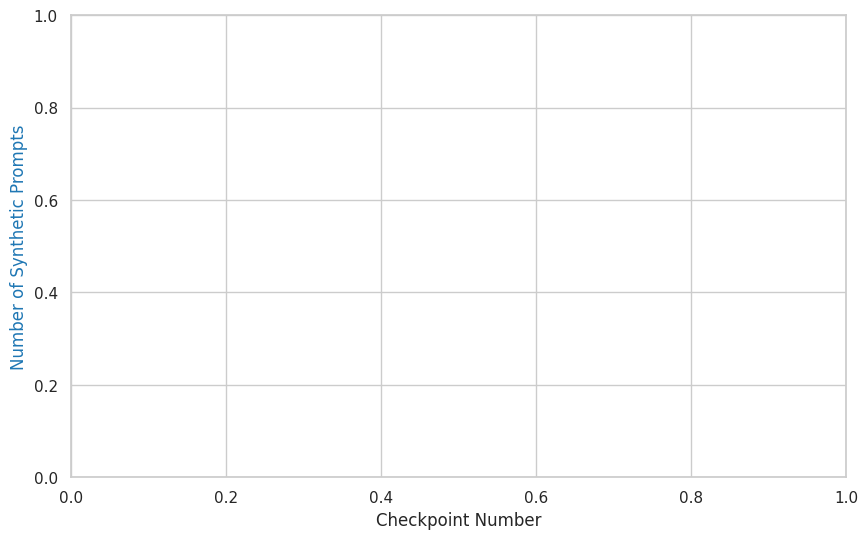

In [12]:
# Visualize the growth of synthetic prompts across checkpoints
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Checkpoint Number')
ax1.set_ylabel('Number of Synthetic Prompts', color='tab:blue')
ax1.plot(stats_df['checkpoint'], stats_df['synthetic_prompts_count'], marker='o', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  # Create a second y-axis
ax2.set_ylabel('Completion Percentage (%)', color='tab:red')
ax2.plot(stats_df['checkpoint'], stats_df['completion_percentage'], marker='s', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Synthetic Prompts Growth Analysis')
fig.tight_layout()
plt.show()

## Analyze Prompt Content

Examine the latest checkpoint file in detail to check the quality of generated prompts.

In [7]:
# Get the latest checkpoint file
latest_checkpoint_num = max(checkpoint_stats.keys())
latest_df = checkpoint_stats[latest_checkpoint_num]['data']

# Display basic info about the latest checkpoint
print(f"Latest checkpoint: {latest_checkpoint_num}")
print(f"Number of synth prompts: {len(latest_df[latest_df['synthetic_prompt'].notna()])}")
print(f"\nColumns in the dataset:")
for col in latest_df.columns:
    print(f" - {col}")

# Display the first few rows of the latest checkpoint
latest_df.head()

Latest checkpoint: 555
Number of synth prompts: 555

Columns in the dataset:
 - id
 - date
 - summary
 - judgement
 - subset_name
 - split_name
 - is_announcement_rule
 - matching_criteria
 - synthetic_prompt


,id,date,summary,judgement,subset_name,split_name,is_announcement_rule,matching_criteria,synthetic_prompt
0,bag_1-17,18.01.2017,18.01.2017\n1/17 - Betriebsratstätigkeit - Arb...,Tenor\n\n\n\n\nAuf die Revision der Beklagten ...,Bundesarbeitsgericht,train,False,NaN,"Erstelle eine prägnante, verständliche Pressem..."
1,bag_1-19,22.01.2019,22.01.2019\n1/19 - Urlaubsabgeltung bei Tod de...,Tenor\n\n\n\n\n1. Die Revision der Beklagten g...,Bundesarbeitsgericht,train,False,NaN,Erstelle eine Pressemitteilung zu folgendem Ge...
2,bag_10-19,20.02.2019,20.02.2019\n10/19 - Kündigung des Chefarztes e...,Tenor\n\n\n\n\nDie Revision der Beklagten gege...,Bundesarbeitsgericht,train,False,NaN,Erstelle eine prägnante Pressemitteilung zum b...
3,bag_11-18,22.02.2018,22.02.2018\n11/18 - Annahmeverzugsvergütung al...,Tenor\n\n\n\n\n1. Die Revision des Beklagten g...,Bundesarbeitsgericht,train,False,NaN,Erstelle aus dem folgenden Gerichtsurteil eine...
4,bag_11-20,27.02.2020,27.02.2020\n11/20 - Kündigungen des Cockpit-Pe...,Tenor\n\n\n\n\nAuf die Revision des Klägers wi...,Bundesarbeitsgericht,train,False,NaN,Erstelle eine professionelle Pressemitteilung ...


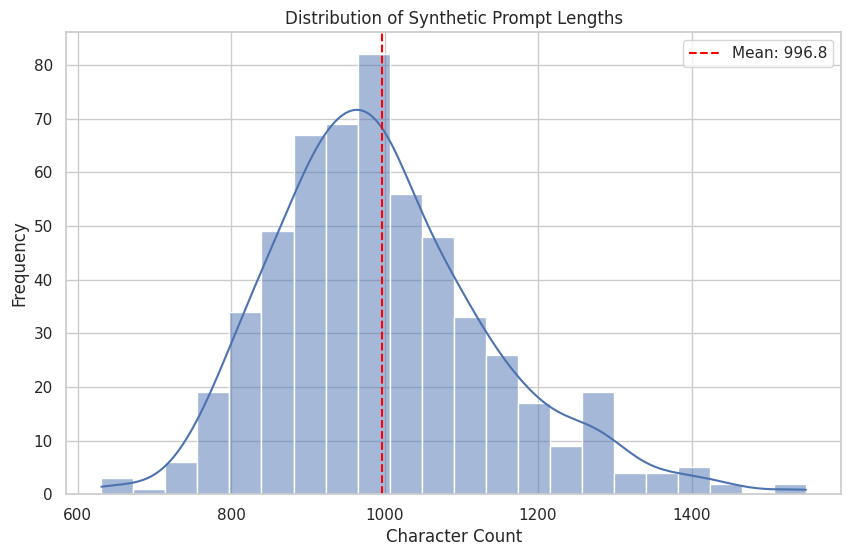

Minimum prompt length: 631
Maximum prompt length: 1549
Average prompt length: 996.8
Number of non-empty prompts: 555 out of 6432 total entries (8.63%)


In [8]:
# Analyze prompt length distribution
if 'synthetic_prompt' in latest_df.columns:
    # Filter out NaN values and create a proper copy
    prompts_df = latest_df.dropna(subset=['synthetic_prompt']).copy()
    
    if len(prompts_df) > 0:
        # Use .loc for assignment to avoid warnings
        prompts_df.loc[:, 'prompt_length'] = prompts_df['synthetic_prompt'].apply(len)
        
        plt.figure(figsize=(10, 6))
        sns.histplot(prompts_df['prompt_length'], kde=True)
        plt.title('Distribution of Synthetic Prompt Lengths')
        plt.xlabel('Character Count')
        plt.ylabel('Frequency')
        plt.axvline(prompts_df['prompt_length'].mean(), color='red', linestyle='--', label=f'Mean: {prompts_df["prompt_length"].mean():.1f}')
        plt.legend()
        plt.show()
        
        print(f"Minimum prompt length: {prompts_df['prompt_length'].min()}")
        print(f"Maximum prompt length: {prompts_df['prompt_length'].max()}")
        print(f"Average prompt length: {prompts_df['prompt_length'].mean():.1f}")
        print(f"Number of non-empty prompts: {len(prompts_df)} out of {len(latest_df)} total entries ({len(prompts_df)/len(latest_df)*100:.2f}%)")
    else:
        print("No non-empty synthetic prompts found in the latest checkpoint.")
else:
    print("No 'synthetic_prompt' column found in the dataset.")

## Sample Prompts

Review a random sample of prompts from the latest checkpoint to manually assess quality.

In [9]:
# Display the most recent synthetic prompts (non-null only)
if 'synthetic_prompt' in latest_df.columns:
    # Filter to get only rows with valid synthetic prompts - create a proper copy
    synth_prompts_df = latest_df.dropna(subset=['synthetic_prompt']).copy()
    
    # Get the last few examples
    num_examples = min(5, len(synth_prompts_df))
    last_examples = synth_prompts_df.tail(num_examples)
    
    print(f"Showing the last {num_examples} synthetic prompts from the latest checkpoint:")
    for i, (_, row) in enumerate(last_examples.iterrows(), 1):
        print(f"\nSynthetic Prompt {i}:")
        print(f"{row['synthetic_prompt']}")
else:
    print("No synthetic prompts found in the latest checkpoint.")

Showing the last 5 synthetic prompts from the latest checkpoint:

Synthetic Prompt 1:
Erstelle eine kurze, prägnante Pressemitteilung für die Öffentlichkeit aus dem folgenden Gerichtsurteil des Bundesfinanzhofs (BFH). Beachte dabei:

1. Beginne mit einem aussagekräftigen Titel, der den Kerninhalt des Urteils zusammenfasst
2. Füge das Datum der Pressemitteilung sowie die Aktenzeichen-Informationen ein
3. Stelle die zentrale Entscheidung des Gerichts in 1-2 kurzen Sätzen dar
4. Erläutere die maßgeblichen Rechtsgrundlagen in verständlicher Sprache
5. Erkläre die Begründung des Gerichts in 2-3 prägnanten Absätzen
6. Verzichte auf detaillierte Tatbestandsmerkmale und prozessuale Details
7. Verwende eine neutrale, sachliche Sprache ohne juristische Fachterminologie
8. Beschränke die Pressemitteilung auf maximal 250 Wörter
9. Füge am Ende die üblichen Kontaktinformationen der Pressestelle hinzu

Die Pressemitteilung soll für Steuerpflichtige und die allgemeine Öffentlichkeit verständlich sein

## Checkpoint Comparison

If multiple checkpoints exist, compare how the content has evolved.

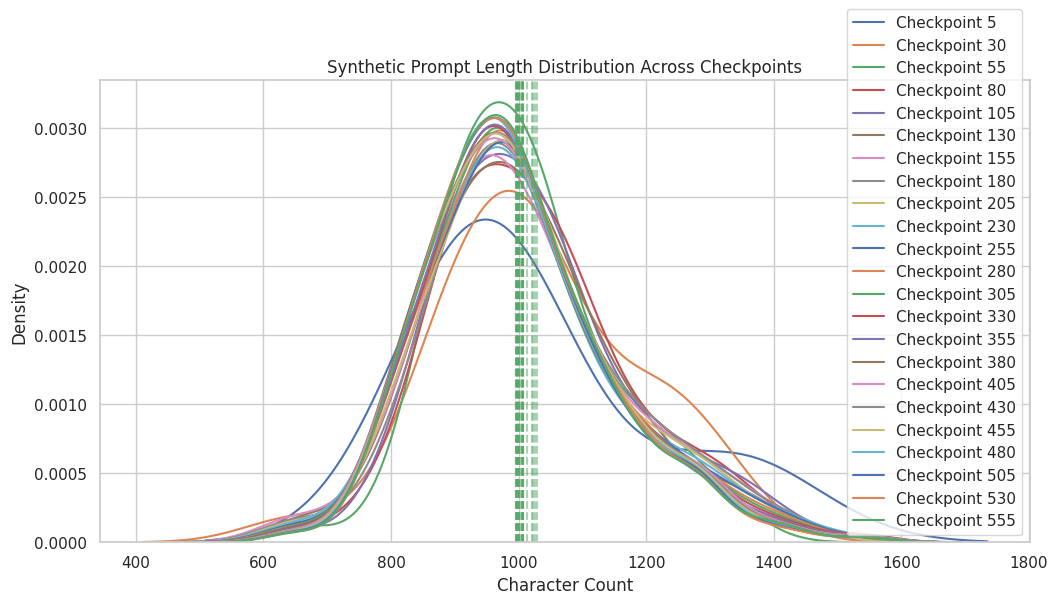

Summary of prompt lengths across checkpoints:


In [10]:
# Compare synthetic prompt length distribution across checkpoints if we have multiple
if len(checkpoint_stats) > 1:
    plt.figure(figsize=(12, 6))
    
    # Track which checkpoints actually have synthetic prompts
    checkpoints_with_prompts = []
    
    for checkpoint_num, stats in checkpoint_stats.items():
        df = stats['data']
        if 'synthetic_prompt' in df.columns:
            # Filter out rows where synthetic_prompt is NaN and create a proper copy
            prompts_df = df.dropna(subset=['synthetic_prompt']).copy()
            if len(prompts_df) > 0:
                # Use .loc for assignment to avoid warnings
                prompts_df.loc[:, 'prompt_length'] = prompts_df['synthetic_prompt'].apply(len)
                sns.kdeplot(prompts_df['prompt_length'], label=f'Checkpoint {checkpoint_num}')
                checkpoints_with_prompts.append(checkpoint_num)
    
    if checkpoints_with_prompts:
        plt.title('Synthetic Prompt Length Distribution Across Checkpoints')
        plt.xlabel('Character Count')
        plt.ylabel('Density')
        plt.legend()
        
        # Add summary statistics to the plot
        for checkpoint_num in checkpoints_with_prompts:
            df = checkpoint_stats[checkpoint_num]['data']
            prompts_df = df.dropna(subset=['synthetic_prompt']).copy()
            prompts_df.loc[:, 'prompt_length'] = prompts_df['synthetic_prompt'].apply(len)
            plt.axvline(prompts_df['prompt_length'].mean(), linestyle='--', 
                        color=plt.gca().lines[-1].get_color(),
                        alpha=0.5)
        
        plt.show()
        
        # Print summary table of prompt lengths
        summary_data = []
        for checkpoint_num in checkpoints_with_prompts:
            df = checkpoint_stats[checkpoint_num]['data']
            prompts_df = df.dropna(subset=['synthetic_prompt']).copy()
            prompts_df.loc[:, 'prompt_length'] = prompts_df['synthetic_prompt'].apply(len)
            summary_data.append({
                'Checkpoint': checkpoint_num,
                'Prompt Count': len(prompts_df),
                'Min Length': prompts_df['prompt_length'].min(),
                'Max Length': prompts_df['prompt_length'].max(),
                'Mean Length': prompts_df['prompt_length'].mean(),
                'Median Length': prompts_df['prompt_length'].median()
            })
        
        print("Summary of prompt lengths across checkpoints:")
        pd.DataFrame(summary_data).set_index('Checkpoint')
    else:
        print("No synthetic prompts found in any checkpoint.")
else:
    print("Need multiple checkpoints with synthetic prompts for comparison.")

## Cost Analysis

If the checkpoint contains information about token counts or API calls, analyze the cost implications.

In [11]:
# Check if we have token count information to estimate costs
token_columns = [col for col in latest_df.columns if 'token' in col.lower()]

if token_columns:
    print("Token-related columns found. Performing cost analysis...")
    
    # Assuming 'input_tokens' and 'output_tokens' columns exist and using hypothetical pricing
    if 'input_tokens' in latest_df.columns and 'output_tokens' in latest_df.columns:
        # Example pricing - adjust based on your actual model and pricing
        INPUT_TOKEN_PRICE = 0.0015 / 1000  # $0.0015 per 1000 tokens
        OUTPUT_TOKEN_PRICE = 0.002 / 1000  # $0.002 per 1000 tokens
        
        total_input_tokens = latest_df['input_tokens'].sum()
        total_output_tokens = latest_df['output_tokens'].sum()
        
        input_cost = total_input_tokens * INPUT_TOKEN_PRICE
        output_cost = total_output_tokens * OUTPUT_TOKEN_PRICE
        total_cost = input_cost + output_cost
        
        print(f"Total input tokens: {total_input_tokens:,}")
        print(f"Total output tokens: {total_output_tokens:,}")
        print(f"Estimated input cost: ${input_cost:.2f}")
        print(f"Estimated output cost: ${output_cost:.2f}")
        print(f"Estimated total cost: ${total_cost:.2f}")
else:
    print("No token-related columns found in the dataset.")

No token-related columns found in the dataset.


## Generation Progress Rate

Analyze how quickly prompts are being generated based on checkpoint timestamps.

Average generation rate: 164.09 prompts/hour
Estimated time to generate 1000 more prompts: 6.09 hours


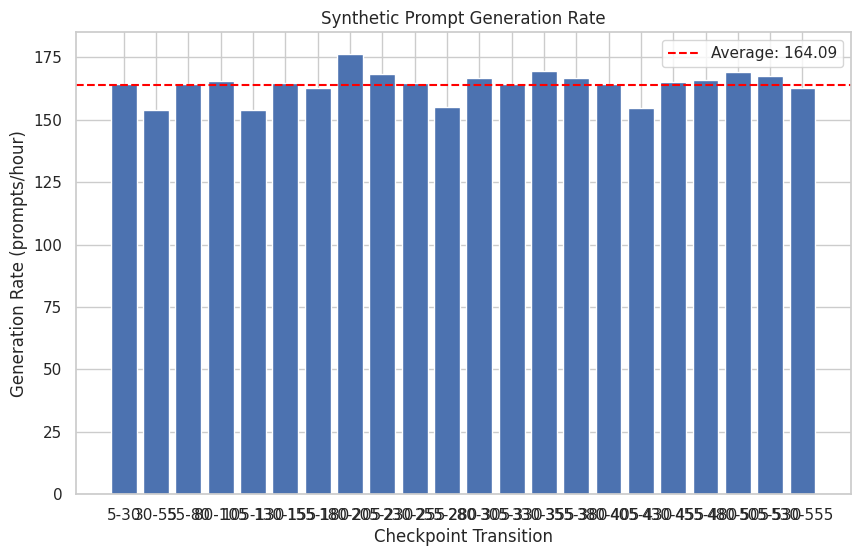

In [12]:
# Try to get file modification times to estimate generation rate
timestamps = {}
for file in checkpoint_files:
    checkpoint_num = int(file.split('_')[-1].split('.')[0])
    timestamps[checkpoint_num] = os.path.getmtime(file)

if len(timestamps) > 1:
    checkpoint_nums = sorted(timestamps.keys())
    
    # Calculate time differences and generation rates
    time_diffs = []
    rates = []
    
    for i in range(1, len(checkpoint_nums)):
        prev_num = checkpoint_nums[i-1]
        curr_num = checkpoint_nums[i]
        
        time_diff = timestamps[curr_num] - timestamps[prev_num]  # in seconds
        prompt_diff = checkpoint_stats[curr_num]['synthetic_prompts_count'] - checkpoint_stats[prev_num]['synthetic_prompts_count']
        
        if time_diff > 0:
            rate = prompt_diff / (time_diff / 3600)  # prompts per hour
            time_diffs.append(time_diff / 3600)  # convert to hours
            rates.append(rate)
    
    if rates:
        # Calculate average generation rate
        avg_rate = sum(rates) / len(rates)
        
        # Estimate time to generate 1000 more prompts
        if avg_rate > 0:
            time_for_1000 = 1000 / avg_rate
            
            print(f"Average generation rate: {avg_rate:.2f} prompts/hour")
            print(f"Estimated time to generate 1000 more prompts: {time_for_1000:.2f} hours")
        else:
            print("Average generation rate is 0 prompts/hour. Cannot estimate completion time.")
            time_for_1000 = float('inf')  # Setting to infinity for reference in later cells
        
        # Visualize generation rate
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(rates)), rates)
        plt.axhline(avg_rate, color='red', linestyle='--', label=f'Average: {avg_rate:.2f}')
        plt.xlabel('Checkpoint Transition')
        plt.ylabel('Generation Rate (prompts/hour)')
        plt.title('Synthetic Prompt Generation Rate')
        plt.xticks(range(len(rates)), [f'{checkpoint_nums[i]}-{checkpoint_nums[i+1]}' for i in range(len(rates))])
        plt.legend()
        plt.show()
    else:
        print("No valid generation rates could be calculated between checkpoints.")
else:
    print("Not enough checkpoints to analyze generation rate.")

## Checking for Duplicates

Verify that synthetic prompts are unique across checkpoints.

In [13]:
# Check for duplicates in the latest checkpoint
if 'synthetic_prompt' in latest_df.columns:
    # First filter out NaN values to avoid counting them as duplicates
    non_null_prompts_df = latest_df.dropna(subset=['synthetic_prompt']).copy()
    
    # Now check for duplicates only among non-null values
    duplicate_count = non_null_prompts_df.duplicated(subset=['synthetic_prompt']).sum()
    duplicate_percent = (duplicate_count / len(non_null_prompts_df)) * 100 if len(non_null_prompts_df) > 0 else 0
    
    print(f"Total prompts in latest checkpoint: {len(latest_df)}")
    print(f"Number of non-null synthetic prompts: {len(non_null_prompts_df)}")
    print(f"Number of duplicate prompts (among non-null): {duplicate_count}")
    print(f"Percentage of duplicates (among non-null): {duplicate_percent:.2f}%")

    # Check for near-duplicates using a simple similarity metric
    if len(non_null_prompts_df) > 1:
        print("\nChecking for near-duplicates (this might take a while for large datasets)...")
        
        # For demonstration, we'll just check a sample of prompts
        sample_size = min(100, len(non_null_prompts_df))
        prompt_sample = non_null_prompts_df['synthetic_prompt'].sample(sample_size).tolist()
        
        import difflib
        similarity_threshold = 0.9
        near_duplicate_pairs = []
        
        for i in range(len(prompt_sample)):
            for j in range(i+1, len(prompt_sample)):
                similarity = difflib.SequenceMatcher(None, prompt_sample[i], prompt_sample[j]).ratio()
                if similarity > similarity_threshold:
                    near_duplicate_pairs.append((i, j, similarity))
        
        if near_duplicate_pairs:
            print(f"Found {len(near_duplicate_pairs)} potential near-duplicate pairs in the sample:")
            for i, j, similarity in near_duplicate_pairs[:3]:  # Show just a few examples
                print(f"\nSimilarity: {similarity:.2f}")
                print(f"Prompt 1: {prompt_sample[i][:100]}...")
                print(f"Prompt 2: {prompt_sample[j][:100]}...")
            if len(near_duplicate_pairs) > 3:
                print(f"...and {len(near_duplicate_pairs) - 3} more pairs.")
        else:
            print("No near-duplicates found in the sample.")
else:
    print("No 'synthetic_prompt' column found in the dataset for duplicate checking.")

Total prompts in latest checkpoint: 6432
Number of non-null synthetic prompts: 555
Number of duplicate prompts (among non-null): 0
Percentage of duplicates (among non-null): 0.00%

Checking for near-duplicates (this might take a while for large datasets)...
No near-duplicates found in the sample.


## Conclusion

Summarize the findings from the checkpoint analysis.

In [14]:
# Print a summary of the findings
print("## Synthetic Prompts Checkpoint Analysis Summary")

print(f"\n### Process Status:")
print(f"- Total checkpoints found: {len(checkpoint_stats)}")
if len(checkpoint_stats) > 0:
    print(f"- Latest checkpoint: {max(checkpoint_stats.keys())}")
    if 'synthetic_prompt' in latest_df.columns:
        non_null_count = latest_df['synthetic_prompt'].notna().sum()
        print(f"- Non-null synthetic prompts: {non_null_count} ({(non_null_count/len(latest_df))*100:.2f}% of total)")

if len(checkpoint_stats) > 1:
    print(f"\n### Generation Progress:")
    first_checkpoint = min(checkpoint_stats.keys())
    last_checkpoint = max(checkpoint_stats.keys())
    total_growth = checkpoint_stats[last_checkpoint]['synthetic_prompts_count'] - checkpoint_stats[first_checkpoint]['synthetic_prompts_count']
    print(f"- Prompt growth: +{total_growth} prompts since first checkpoint")
    if 'avg_rate' in locals() and avg_rate > 0:
        print(f"- Average generation rate: {avg_rate:.2f} prompts/hour")
        print(f"- Estimated completion time for 1000 more prompts: {time_for_1000:.2f} hours")
    elif 'avg_rate' in locals():
        print(f"- No prompt growth detected between checkpoints (rate: {avg_rate:.2f} prompts/hour)")

print(f"\n### Data Quality:")
if 'duplicate_count' in locals():
    # Use non_null_prompts_df here to get the proper count of non-null prompts
    non_null_count = latest_df['synthetic_prompt'].notna().sum() if 'synthetic_prompt' in latest_df.columns else 0
    print(f"- Duplicate prompts: {duplicate_count} ({duplicate_percent:.2f}% of non-null prompts)")

if 'token_columns' in locals() and token_columns:
    print(f"\n### Resource Usage:")
    if 'total_cost' in locals():
        print(f"- Estimated cost so far: ${total_cost:.2f}")

print("\nRecommendations:")
if len(checkpoint_stats) < 2:
    print("- Create more checkpoints to enable better progress tracking")
elif 'total_growth' in locals() and total_growth == 0:
    print("- Investigate why no new prompts are being generated between checkpoints")
elif 'duplicate_count' in locals() and duplicate_percent > 5:
    print("- Review generation process to reduce duplicates")
elif 'avg_rate' in locals() and avg_rate > 0 and avg_rate < 10:
    print("- Consider optimization to improve generation rate")
else:
    print("- Process appears to be running as expected")

## Synthetic Prompts Checkpoint Analysis Summary

### Process Status:
- Total checkpoints found: 23
- Latest checkpoint: 555
- Non-null synthetic prompts: 555 (8.63% of total)

### Generation Progress:
- Prompt growth: +550 prompts since first checkpoint
- Average generation rate: 164.09 prompts/hour
- Estimated completion time for 1000 more prompts: 6.09 hours

### Data Quality:
- Duplicate prompts: 0 (0.00% of non-null prompts)

Recommendations:
- Process appears to be running as expected


## Checkpoint Cleanup

This section helps manage disk space by keeping only the latest three valid checkpoints and removing others. This is especially useful when running long-term synthetic prompt generation, which can create many large checkpoint files that fill up disk space.

In [ ]:
# Define a function to clean up checkpoint files
def cleanup_checkpoints(keep_latest=3, backup_dir='../checkpoints/backup/', dry_run=True):
    """Clean up checkpoint files, keeping only the latest N valid ones.
    
    Args:
        keep_latest: Number of valid checkpoint files to keep
        backup_dir: Directory to move important checkpoints to before deletion
        dry_run: If True, only show what would be deleted without actually deleting
    """
    import os
    import shutil
    import pandas as pd
    from datetime import datetime
    
    # Ensure backup directory exists
    if not os.path.exists(backup_dir):
        os.makedirs(backup_dir)
        print(f"Created backup directory: {backup_dir}")
    
    # Get all checkpoint files and their stats
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, 'synthetic_prompts_*.csv'))
    
    # Create a list to track valid checkpoints
    valid_checkpoints = []
    corrupt_checkpoints = []
    
    # Analyze each checkpoint file
    for file in checkpoint_files:
        checkpoint_num = int(file.split('_')[-1].split('.')[0])
        file_size_mb = os.path.getsize(file) / (1024 * 1024)
        
        try:
            # Try to load the file to check if it's valid
            df = pd.read_csv(file, on_bad_lines='skip', error_bad_lines=False)
            
            # Check if it contains valid synthetic prompts
            has_synthetic_prompts = 'synthetic_prompt' in df.columns and df['synthetic_prompt'].notna().sum() > 0
            prompt_count = df['synthetic_prompt'].notna().sum() if has_synthetic_prompts else 0
            
            # Add to valid checkpoints if it has prompts
            if has_synthetic_prompts:
                valid_checkpoints.append({
                    'num': checkpoint_num,
                    'file': file,
                    'size_mb': file_size_mb,
                    'prompt_count': prompt_count,
                    'mtime': os.path.getmtime(file)
                })
            else:
                print(f"File {os.path.basename(file)} has no valid synthetic prompts ({file_size_mb:.2f} MB)")
                corrupt_checkpoints.append({
                    'num': checkpoint_num,
                    'file': file,
                    'size_mb': file_size_mb,
                    'reason': 'No synthetic prompts',
                    'mtime': os.path.getmtime(file)
                })
        except Exception as e:
            print(f"Error analyzing {os.path.basename(file)}: {str(e)}")
            corrupt_checkpoints.append({
                'num': checkpoint_num,
                'file': file,
                'size_mb': file_size_mb,
                'reason': str(e),
                'mtime': os.path.getmtime(file)
            })
    
    # Sort by checkpoint number (typically also sorted by time)
    valid_checkpoints.sort(key=lambda x: x['num'])
    corrupt_checkpoints.sort(key=lambda x: x['num'])
    
    # Identify the files to keep and delete
    keep_files = valid_checkpoints[-keep_latest:] if valid_checkpoints else []
    delete_files = valid_checkpoints[:-keep_latest] if valid_checkpoints else []
    
    # Save some stats about files we're keeping
    total_size_to_keep = sum(f['size_mb'] for f in keep_files)
    
    # Create a backup of first checkpoint ever if it exists and not in keep_files
    if valid_checkpoints and valid_checkpoints[0] not in keep_files:
        first_checkpoint = valid_checkpoints[0]
        keep_files.append(first_checkpoint)
        delete_files.remove(first_checkpoint)
        print(f"\nPreserving first checkpoint: {os.path.basename(first_checkpoint['file'])}")
    
    # Report what we found
    print(f"\nFound {len(valid_checkpoints)} valid checkpoints with synthetic prompts")
    print(f"Found {len(corrupt_checkpoints)} corrupt or empty checkpoints")
    print(f"Keeping {len(keep_files)} checkpoints ({total_size_to_keep:.2f} MB total)")
    
    # Print what corrupt files will be deleted
    if corrupt_checkpoints:
        corrupt_size = sum(f['size_mb'] for f in corrupt_checkpoints)
        print(f"\nCorrupt/empty checkpoints to be {'removed' if not dry_run else 'marked for removal'} ({len(corrupt_checkpoints)}):\n")
        for info in corrupt_checkpoints:
            time_str = datetime.fromtimestamp(info['mtime']).strftime('%Y-%m-%d %H:%M:%S')
            print(f"- {os.path.basename(info['file'])}: {info['size_mb']:.2f} MB, Last modified: {time_str}")
            print(f"  Reason: {info['reason']}")
        print(f"\nTotal corrupt checkpoint size: {corrupt_size:.2f} MB")
    
    # Stop here if there's nothing to delete
    if not delete_files and not corrupt_checkpoints:
        print("No checkpoints need to be deleted.")
        return
    
    # Print what valid files will be deleted
    if delete_files:
        print(f"\nValid but older checkpoints to be {'removed' if not dry_run else 'marked for removal'} ({len(delete_files)}):\n")
        
        # Calculate the total size to be deleted
        total_size_to_delete = 0
        
        for info in delete_files:
            time_str = datetime.fromtimestamp(info['mtime']).strftime('%Y-%m-%d %H:%M:%S')
            print(f"- {os.path.basename(info['file'])}: {info['prompt_count']} prompts, {info['size_mb']:.2f} MB, Last modified: {time_str}")
            total_size_to_delete += info['size_mb']
        
        print(f"\nTotal disk space to be freed from valid files: {total_size_to_delete:.2f} MB")
    
    # List files we'll keep
    print(f"\nCheckpoints to keep ({len(keep_files)}):\n")
    for info in keep_files:
        time_str = datetime.fromtimestamp(info['mtime']).strftime('%Y-%m-%d %H:%M:%S')
        print(f"- {os.path.basename(info['file'])}: {info['prompt_count']} prompts, {info['size_mb']:.2f} MB, Last modified: {time_str}")
    
    # Total size that will be freed
    total_freed = (sum(f['size_mb'] for f in delete_files) + sum(f['size_mb'] for f in corrupt_checkpoints))
    print(f"\nTotal disk space to be freed: {total_freed:.2f} MB")
    
    # Execute deletion if not a dry run
    if not dry_run:
        print(f"\nProceeding with deletion...")
        # Delete corrupt files first
        for info in corrupt_checkpoints:
            try:
                os.remove(info['file'])
                print(f"Deleted corrupt file: {os.path.basename(info['file'])}")
            except Exception as e:
                print(f"Error deleting {os.path.basename(info['file'])}: {str(e)}")
        
        # Then delete old but valid files
        for info in delete_files:
            try:
                os.remove(info['file'])
                print(f"Deleted: {os.path.basename(info['file'])}")
            except Exception as e:
                print(f"Error deleting {os.path.basename(info['file'])}: {str(e)}")
        
        print(f"Done! Freed up approximately {total_freed:.2f} MB")
    else:
        print(f"\nThis was a dry run. No files were actually deleted.")
        print(f"Run with `dry_run=False` to actually delete the files.")

# Run the cleanup function with default parameters (dry run)
cleanup_checkpoints(keep_latest=3, dry_run=True)

Error analyzing synthetic_prompts_2130.csv: Error tokenizing data. C error: EOF inside string starting at row 6000

Preserving first checkpoint: synthetic_prompts_5.csv

Found 27 valid checkpoints with synthetic prompts
Keeping 4 checkpoints (750.30 MB total)

Checkpoints to be marked for removal (23):

- synthetic_prompts_130.csv: 130 prompts, 248.80 MB, Last modified: 2025-03-28 17:08:28
- synthetic_prompts_205.csv: 205 prompts, 248.87 MB, Last modified: 2025-03-28 17:35:19
- synthetic_prompts_280.csv: 280 prompts, 248.94 MB, Last modified: 2025-03-28 18:03:00
- synthetic_prompts_330.csv: 330 prompts, 248.99 MB, Last modified: 2025-03-28 18:21:09
- synthetic_prompts_405.csv: 405 prompts, 249.06 MB, Last modified: 2025-03-28 18:48:08
- synthetic_prompts_480.csv: 480 prompts, 249.13 MB, Last modified: 2025-03-28 19:15:58
- synthetic_prompts_555.csv: 555 prompts, 249.21 MB, Last modified: 2025-03-28 19:43:00
- synthetic_prompts_655.csv: 655 prompts, 249.30 MB, Last modified: 2025-03-28 

In [ ]:
# Execute the actual cleanup (after reviewing the dry run results)
# Uncomment and run only after confirming the dry run results look correct
# cleanup_checkpoints(keep_latest=3, dry_run=False)

Error analyzing synthetic_prompts_2130.csv: Error tokenizing data. C error: EOF inside string starting at row 6000

Preserving first checkpoint: synthetic_prompts_5.csv

Found 27 valid checkpoints with synthetic prompts
Keeping 4 checkpoints (750.30 MB total)

Checkpoints to be removed (23):

- synthetic_prompts_130.csv: 130 prompts, 248.80 MB, Last modified: 2025-03-28 17:08:28
- synthetic_prompts_205.csv: 205 prompts, 248.87 MB, Last modified: 2025-03-28 17:35:19
- synthetic_prompts_280.csv: 280 prompts, 248.94 MB, Last modified: 2025-03-28 18:03:00
- synthetic_prompts_330.csv: 330 prompts, 248.99 MB, Last modified: 2025-03-28 18:21:09
- synthetic_prompts_405.csv: 405 prompts, 249.06 MB, Last modified: 2025-03-28 18:48:08
- synthetic_prompts_480.csv: 480 prompts, 249.13 MB, Last modified: 2025-03-28 19:15:58
- synthetic_prompts_555.csv: 555 prompts, 249.21 MB, Last modified: 2025-03-28 19:43:00
- synthetic_prompts_655.csv: 655 prompts, 249.30 MB, Last modified: 2025-03-28 20:19:46
- 